In [1]:
import geopandas as gpd
import rasterio as rio
from rasterio import features
from rasterio import Affine
from rasterio.plot import show
import rioxarray as riox
import xarray as xr
import glob
import os
import numpy as np
import re
import pandas as pd
from xrspatial import convolution, focal
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import jaccard_score

In [2]:
def shp2mask(shp, xr_object, transform, outshape, fill=0, dtype='int16', **kwargs):
    raster = features.rasterize(shp, fill=fill, transform=transform,
                                out_shape=outshape, dtype=dtype, **kwargs)
    return xr.DataArray(raster,
                        coords=(xr_object.coords['y'].values, xr_object.coords['x']),
                        dims=('y', 'x'))

def apply_slope(y):
    from sklearn.linear_model import LinearRegression
    X = np.arange(0, len(y))
    if len(y[~np.isnan(y)]) > 3:
        ts = LinearRegression().fit(X[~np.isnan(y)].reshape(-1, 1), y[~np.isnan(y)])
        return ts.coef_
    else:
        return np.nan

In [3]:
from dask.distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=8, threads_per_worker=2, processes=True)
client = Client(cluster)
client.amm.start()
display(client)

/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44591 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:44591/status,
Dashboard: http://127.0.0.1:44591/status,Workers: 8
Total threads: 16,Total memory: 15.49 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44919,Workers: 8
Dashboard: http://127.0.0.1:44591/status,Total threads: 16
Started: Just now,Total memory: 15.49 GiB
Comm: tcp://127.0.0.1:37347,Total threads: 2
Dashboard: http://127.0.0.1:34305/status,Memory: 1.94 GiB
Nanny: tcp://127.0.0.1:39707,


In [22]:
suffix_list= ['_rgb_5cm', '_rgb_10cm', '_rgb_15cm',
              '_rgb_tpi_5cm', '_rgb_tpi_ndvi_5cm',
              '_rgb_tpi_10cm', '_rgb_tpi_ndvi_10cm',
              '_rgb_tpi_15cm', '_rgb_tpi_ndvi_15cm']

focal_area_ha_list = [1.0, 5.0, 10.0, 15.0, 20.0]

cell_size = 5.0

cper_f = '/mnt/c/Users/TBGPEA-Sean/Desktop/Pdogs_UAS/cper_pdog_pastures_2017_clip.shp'

In [5]:
cper = gpd.read_file(cper_f)
transform = rio.transform.from_origin(cper.total_bounds[0],cper.total_bounds[3],cell_size, cell_size)
cper_ras = features.rasterize(zip(cper.geometry.buffer(cell_size), cper.OBJECTID),
                   fill=0, 
                   transform=transform,
                   out_shape=(int(np.ceil((cper.total_bounds[3] - cper.total_bounds[1])/cell_size)),
                              int(np.ceil((cper.total_bounds[2] - cper.total_bounds[0])/cell_size))),
                   dtype=int)
cper_xr = xr.DataArray(cper_ras, 
             coords=(np.arange(cper.total_bounds[3], cper.total_bounds[1], -cell_size),
                    np.arange(cper.total_bounds[0], cper.total_bounds[2], cell_size)),
             dims=('y', 'x'))
cper_xr = cper_xr.where(cper_xr != 0)

In [6]:
da_active =  riox.open_rasterio('./ground_data/PdogMapping_Sept2021/Sept2021_active_yrs.tif').squeeze()
da_old =  riox.open_rasterio('./ground_data/PdogMapping_Sept2021/Sept2021_old_yrs.tif').squeeze()

df_active = da_active.to_dataframe(name='yrs_active').drop(columns='spatial_ref')
df_old = da_old.to_dataframe(name='yrs_old').drop(columns='spatial_ref')

In [7]:
df_val = pd.DataFrame(columns=['suffix', 'focal_area_ha', 'pts_thresh', 'jscore'])
idx=0

In [23]:
for suffix in suffix_list:
    if suffix in df_val.suffix.unique():
        continue
    else:
        print('----- ' + suffix + ' -----')
        shps_f_list = glob.glob('./cnn_pred_results/burrow_pts_pred_*' + suffix + '.shp')
        burrow_area_thresh = None

        print('...calculating burrow count')
        pts_list = []
        for i in tqdm(np.unique(cper_xr.values)):
            if np.isnan(i):
                continue
            else:
                past_row = cper[cper['OBJECTID'] == i]
                shps_f_list_sub = [x for x in shps_f_list if past_row['Past_Name_'].iloc[0] in x]
                for f in shps_f_list_sub:
                    pts_tmp = gpd.read_file(f)
                    pts_tmp = pts_tmp[pts_tmp.geometry != None]
                    if burrow_area_thresh is not None:
                        pts_tmp['area'] = pts_tmp['area'].astype('int')
                        pts_tmp = pts_tmp[pts_tmp['area'] >= burrow_area_thresh]
                    pts_xr = shp2mask(pts_tmp.geometry, cper_xr, cper_xr.rio.transform(), cper_xr.shape,
                                      default_value=1, merge_alg=features.MergeAlg.add)
                    pts_list.append(pts_xr.where(pts_xr != 0))

        print('...calculating burrow density for each focal area')
        for focal_area_ha in tqdm(focal_area_ha_list):
            pts_all_xr = xr.DataArray(np.nanmean(pts_list, axis=0), 
                         coords=(cper_xr.y, cper_xr.x),
                         dims=('y', 'x'))
            radius_m = np.sqrt(focal_area_ha * 1e4) / np.pi
            cellsize_x, cellsize_y = convolution.calc_cellsize(pts_xr)
            kernel = convolution.circle_kernel(cellsize_x, cellsize_y, radius=radius_m)
            pts_density_xr = focal.apply(pts_all_xr,
                                                kernel, 
                                                focal._calc_sum)
            pts_density_xr = pts_density_xr / focal_area_ha

            pts_density_xr = pts_density_xr.where(da_active.notnull())

            df_pts_density = pts_density_xr.to_dataframe(name='pts_density').drop(columns='spatial_ref')

            df_out = pd.merge(
                pd.merge(
                    df_active, df_old, left_index=True, right_index=True),
                df_pts_density, left_index=True, right_index=True)

            for pts_thresh in range(0, 51, 2):
                df_out['y_true'] = df_out['yrs_active'] > 0
                df_out['y_pred'] = df_out['pts_density'] >= pts_thresh
                jscore = jaccard_score(y_true=df_out['y_true'],
                              y_pred=df_out['y_pred'])
                df_val = pd.concat([df_val, pd.DataFrame({'suffix': suffix,
                                                          'focal_area_ha': focal_area_ha,
                                                          'pts_density': pts_thresh,
                                                          'jscore': jscore
                                                         }, index=[idx])])
                idx+=1

----- _rgb_15cm -----
...calculating burrow count


100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.48it/s]


...calculating burrow density for each focal area


  0%|                                                                                             | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_8103/830790504.py:29: RuntimeWarning: Mean of empty slice
  pts_all_xr = xr.DataArray(np.nanmean(pts_list, axis=0),
 20%|█████████████████                                                                    | 1/5 [00:14<00:59, 14.79s/it]/tmp/ipykernel_8103/830790504.py:29: RuntimeWarning: Mean of empty slice
  pts_all_xr = xr.DataArray(np.nanmean(pts_list, axis=0),
 40%|██████████████████████████████████                                                   | 2/5 [00:34<00:52, 17.43s/it]/tmp/ipykernel_8103/830790504.py:29: RuntimeWarning: Mean of empty slice
  pts_all_xr = xr.DataArray(np.nanmean(pts_list, axis=0),
 60%|███████████████████████████████████████████████████                                  | 3/5 [01:00<00:43, 21.62s/it]/tmp/ipykernel_8103/830790504.py:29: RuntimeWarning: Mean of empty slice
  pts_all_xr = xr.DataArray(np.nanmean(pts_list, axis=

In [24]:
df_val['resolution'] = df_val['suffix'].apply(lambda x: int(re.sub('cm', '', x.split('_')[-1])))
df_val['inputs'] = df_val['suffix'].apply(lambda x: ' + '.join(x.split('_')[1:-1]).upper())

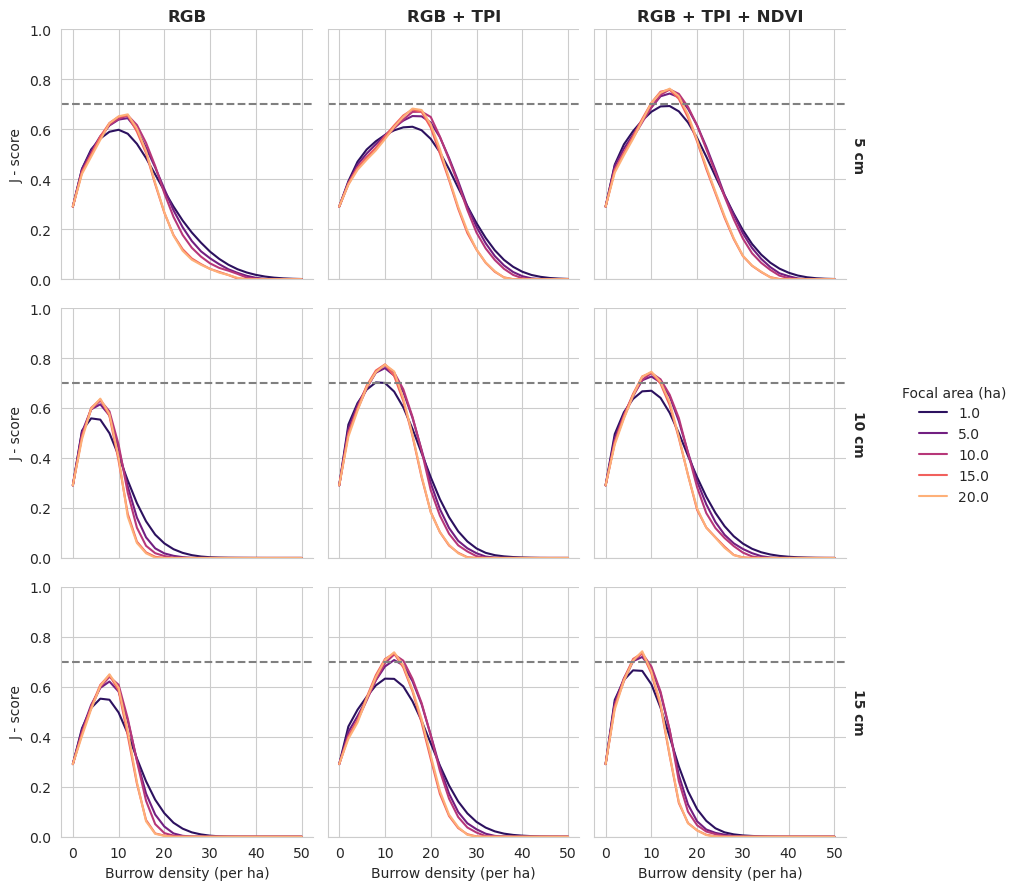

In [30]:
sns.set_style("whitegrid")
g = sns.FacetGrid(df_val, col='inputs', row='resolution', hue='focal_area_ha', 
                  col_order=['RGB', 'RGB + TPI', 'RGB + TPI + NDVI'],
                  palette='magma', ylim=(0.0, 1.0), legend_out=True, margin_titles=True)
g.map_dataframe(sns.lineplot, x='pts_density', y='jscore')
g.add_legend(title='Focal area (ha)', borderaxespad=0)
for ax in g.axes.flatten():
    ax.set_ylabel('J - score')
    ax.set_xlabel('Burrow density (per ha)')
    ax.set_title(re.sub('inputs = ', '', ax.get_title()), fontweight='bold')
    ax.axhline(y=0.70, linestyle='dashed', color='grey')
for margin_title in g._margin_titles_texts:
    margin_title.set_fontweight('bold')
    margin_title.set_text(re.sub('resolution = ', '', margin_title.get_text() + ' cm'))

plt.savefig('./results_figs/jscore_and_burrow_density_by_area_res_inputs.png', dpi=300, bbox_inches='tight', pad_inches=0.5)
plt.show()

In [26]:
df_val_smry = pd.DataFrame(df_val.groupby(['suffix', 'focal_area_ha']).apply(
    lambda x: x['pts_density'][x['jscore'] == x['jscore'].max()])).droplevel(level=2)
df_val_smry['jscore'] = df_val.groupby(['suffix', 'focal_area_ha']).apply(lambda x: x['jscore'].max())
df_val_smry = df_val_smry.reset_index()
df_val_smry['resolution'] = df_val_smry['suffix'].apply(lambda x: int(re.sub('cm', '', x.split('_')[-1])))
df_val_smry['inputs'] = df_val_smry['suffix'].apply(lambda x: ' + '.join(x.split('_')[1:-1]).upper())
#display(round(df_val_smry, 2))

In [27]:
#df_val_smry.sort_values(['inputs', 'resolution', 'focal_area_ha'])

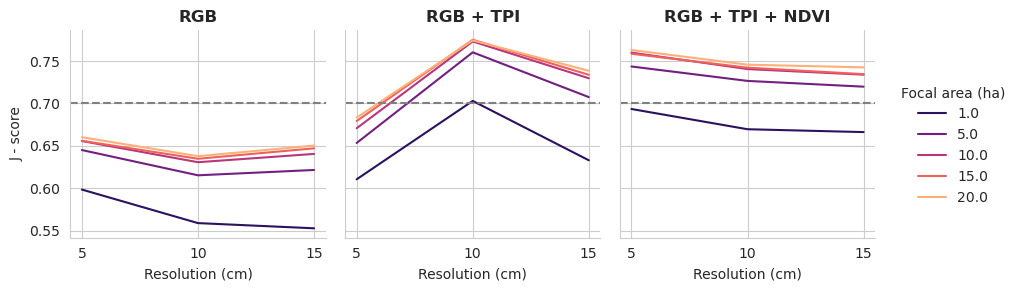

In [29]:
g = sns.FacetGrid(df_val_smry, col='inputs', hue='focal_area_ha', palette='magma')
g.map_dataframe(sns.lineplot, x='resolution', y='jscore', ci=None)
g.add_legend(title='Focal area (ha)', borderaxespad=0)
for ax in g.axes.flatten():
    ax.set_ylabel('J - score')
    ax.set_xlabel('Resolution (cm)')
    ax.set_title(re.sub('inputs = ', '', ax.get_title()), fontweight='bold')
    ax.axhline(y=0.70, linestyle='dashed', color='grey')
    ax.set_xticks([5.0, 10.0, 15.0])
plt.savefig('./results_figs/jscore_and_resolution_best_by_area.png', dpi=300, bbox_inches='tight', pad_inches=0.5)
plt.show()

In [69]:
suffix = '_rgb_tpi_10cm'
shps_f_list = glob.glob('./cnn_pred_results/burrow_pts_pred_*' + suffix + '.shp')
burrow_area_thresh = None

print('...calculating burrow count')
pts_list = []
for i in tqdm(np.unique(cper_xr.values)):
    if np.isnan(i):
        continue
    else:
        past_row = cper[cper['OBJECTID'] == i]
        shps_f_list_sub = [x for x in shps_f_list if past_row['Past_Name_'].iloc[0] in x]
        for f in shps_f_list_sub:
            pts_tmp = gpd.read_file(f)
            pts_tmp = pts_tmp[pts_tmp.geometry != None]
            if burrow_area_thresh is not None:
                pts_tmp['area'] = pts_tmp['area'].astype('int')
                pts_tmp = pts_tmp[pts_tmp['area'] >= burrow_area_thresh]
            pts_xr = shp2mask(pts_tmp.geometry, cper_xr, cper_xr.rio.transform(), cper_xr.shape,
                              default_value=1, merge_alg=features.MergeAlg.add)
            pts_list.append(pts_xr.where(pts_xr != 0))

print('...calculating burrow density at specified focal area')
focal_area_ha = 15.0
pts_all_xr = xr.DataArray(np.nanmean(pts_list, axis=0), 
             coords=(cper_xr.y, cper_xr.x),
             dims=('y', 'x'))
radius_m = np.sqrt(focal_area_ha * 1e4) / np.pi
cellsize_x, cellsize_y = convolution.calc_cellsize(pts_xr)
kernel = convolution.circle_kernel(cellsize_x, cellsize_y, radius=radius_m)
pts_density_xr = focal.apply(pts_all_xr,
                                    kernel, 
                                    focal._calc_sum)
pts_density_xr = pts_density_xr / focal_area_ha

pts_density_xr = pts_density_xr.where(da_active.notnull())

...calculating burrow count


100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.53it/s]
/tmp/ipykernel_3724/2941082186.py:25: RuntimeWarning: Mean of empty slice
  pts_all_xr = xr.DataArray(np.nanmean(pts_list, axis=0),


...calculating burrow density for each focal area


In [73]:
pts_density_xr.rio.to_raster('./cnn_pred_results/tifs/burrow_density' + suffix + '.tif')

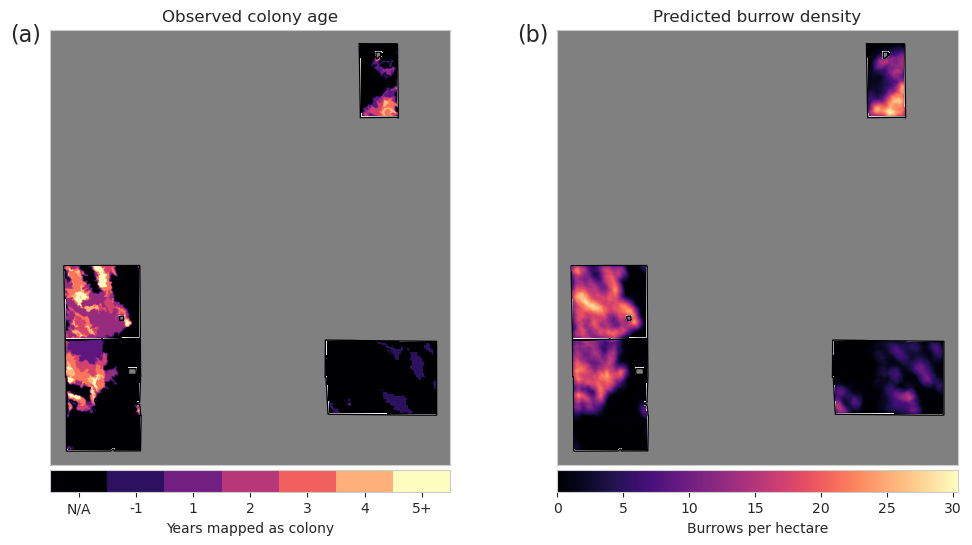

In [70]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import BoundaryNorm
from matplotlib.colorbar import ColorbarBase
cmap_density = 'magma'
pts_thresh = df_val_smry['pts_density'][df_val_smry.index==0][0]
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
plot_buff_m = 300
cper.plot(fc='white', ec='black', ax=axs[0])
show(da_active.data, ax=axs[0], transform=da_active.rio.transform(), zorder=5, cmap=cmap_density)
show(da_old.where(da_old == 1).data, ax=axs[0], transform=da_old.rio.transform(), clim=(0, 6), zorder=8, cmap=cmap_density)
p_active = show(da_active.where(da_active > 0).data, ax=axs[0], transform=da_active.rio.transform(),
                clim=(-1, 6), zorder=10, cmap=cmap_density)
axs[0].set_title('Observed colony age')

cper.plot(fc='white', ec='black', ax=axs[1])
p_density = show(pts_density_xr.data, ax=axs[1], transform=pts_density_xr.rio.transform(), zorder=10, cmap=cmap_density)
axs[1].set_title('Predicted burrow density')

for ax in axs:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_xlim((cper.total_bounds[0]-plot_buff_m, cper.total_bounds[2]+plot_buff_m))
    ax.set_ylim((cper.total_bounds[1]-plot_buff_m, cper.total_bounds[3]+plot_buff_m))
    ax.set_facecolor('grey')
axs[0].annotate('(a)', (-0.1, 0.975), xycoords='axes fraction', fontsize=16)
axs[1].annotate('(b)', (-0.1, 0.975), xycoords='axes fraction', fontsize=16)

# colorbar for first plot
divider1 = make_axes_locatable(axs[0])
cax1 = divider1.append_axes('bottom', size='5%', pad=0.05)
cbar1 = ColorbarBase(ax=cax1, 
                     cmap=plt.get_cmap(cmap_density, 7), 
                     norm=BoundaryNorm(np.arange(0, 8), 8),
                     ticks=np.arange(0.5, 7.5),
                     label='Years mapped as colony',
                     orientation='horizontal')
cbar1.ax.set_xticklabels(['N/A', -1, 1, 2, 3, 4, '5+'])  # horizontal colorbar

# colorbar for second plot
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes('bottom', size='5%', pad=0.05)
fig.colorbar(p_density.get_images()[0],
             cax=cax2,
             orientation='horizontal', 
             label='Burrows per hectare')
plt.savefig('./results_figs/colony_age_and_burrow_density_map' + suffix + '.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

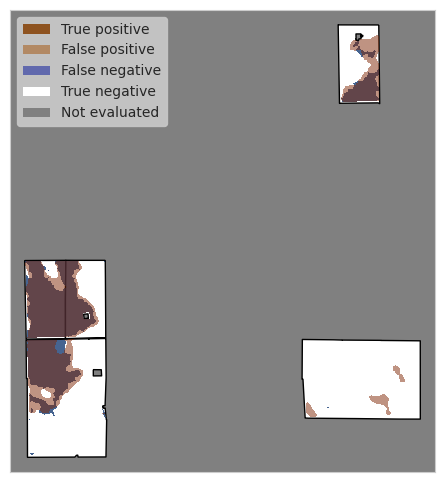

In [71]:
from matplotlib.patches import Patch
fig, ax = plt.subplots(ncols=1, figsize=(6, 6))
cper.plot(fc='white', ec='black', ax=ax, zorder=1)
show((da_active > 0).where(da_active > 0).data, ax=ax, transform=pts_density_xr.rio.transform(), 
     cmap='Blues', clim=(0, 1), alpha=0.75, zorder=5)
show((pts_density_xr >= pts_thresh).where(pts_density_xr >= pts_thresh).data, ax=ax, transform=pts_density_xr.rio.transform(),
     cmap='Oranges', clim=(0, 1), alpha=0.5, zorder=10)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

legend_elements = [Patch(facecolor='#854004', alpha=0.85, edgecolor='none',
                         label='True positive'),
                   Patch(facecolor='#ad7645', alpha=0.75, edgecolor='none',
                         label='False positive'),
                   Patch(facecolor='#414ba6', edgecolor='none', alpha=0.75,
                         label='False negative'),
                   Patch(facecolor='white', edgecolor='none',
                         label='True negative'),
                   Patch(facecolor='grey', edgecolor='none',
                         label='Not evaluated')]
ax.legend(handles=legend_elements, loc='upper left', facecolor='lightgrey')
ax.set_facecolor('grey')
plot_buff_m = 300
ax.set_xlim((cper.total_bounds[0]-plot_buff_m, cper.total_bounds[2]+plot_buff_m))
ax.set_ylim((cper.total_bounds[1]-plot_buff_m, cper.total_bounds[3]+plot_buff_m))
plt.savefig('./results_figs/colony_pred_' + suffix + '.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [72]:
print('Colony area predicted from burrow density: ')
print('  ', np.round(((pts_density_xr >= pts_thresh).sum()*5.0**2*0.0001).values, 1), 'ha')

print('Colony area mapped in 2021: ')
print('  ', np.round(((da_active > 0).sum()*5.0**2*0.0001).values, 1), 'ha')

print('Colony area mapped in 2021 plus colonies abandoned for 1 year: ')
print('  ', 
      np.round(((da_active > 0).sum()*5.0**2*0.0001).values + ((da_old == 1).sum()*5.0**2*0.0001).values, 1), 
      'ha')

print('-------------')

print('Colony area predicted from burrow density excluding 29-30: ')
print('  ', np.round(((pts_density_xr >= pts_thresh).where(cper_xr != 5).sum()*5.0**2*0.0001).values, 1), 'ha')

print('Colony area mapped in 2021 excluding 29-30: ')
print('  ', np.round(((da_active > 0).where(cper_xr != 5).sum()*5.0**2*0.0001).values, 1), 'ha')

Colony area predicted from burrow density: 
   417.7 ha
Colony area mapped in 2021: 
   337.8 ha
Colony area mapped in 2021 plus colonies abandoned for 1 year: 
   425.5 ha
-------------
Colony area predicted from burrow density excluding 29-30: 
   393.2 ha
Colony area mapped in 2021 excluding 29-30: 
   337.1 ha


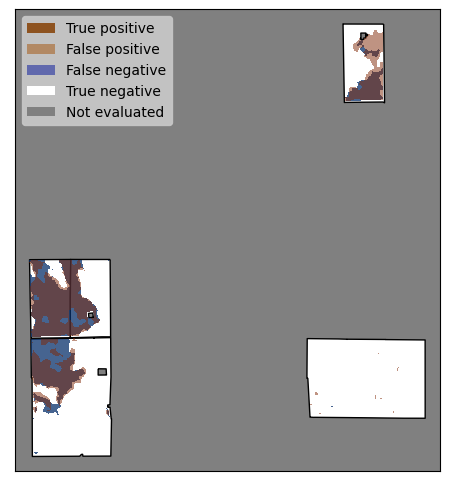

In [40]:
bm_slope_thresh = -0.1

fig, ax = plt.subplots(ncols=1, figsize=(6, 6))
cper.plot(fc='white', ec='black', ax=ax, zorder=1)
show((da_active > 0).where(da_active > 0).data, ax=ax, transform=pts_density_xr.rio.transform(), 
     cmap='Blues', clim=(0, 1), alpha=0.75, zorder=5)
show((pts_density_xr >= pts_thresh).where((pts_density_xr >= pts_thresh) & (bm_slope_z < bm_slope_thresh)).data, ax=ax, transform=pts_density_xr.rio.transform(),
     cmap='Oranges', clim=(0, 1), alpha=0.5, zorder=10)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

legend_elements = [Patch(facecolor='#854004', alpha=0.85, edgecolor='none',
                         label='True positive'),
                   Patch(facecolor='#ad7645', alpha=0.75, edgecolor='none',
                         label='False positive'),
                   Patch(facecolor='#414ba6', edgecolor='none', alpha=0.75,
                         label='False negative'),
                   Patch(facecolor='white', edgecolor='none',
                         label='True negative'),
                   Patch(facecolor='grey', edgecolor='none',
                         label='Not evaluated')]
ax.legend(handles=legend_elements, loc='upper left', facecolor='lightgrey')
ax.set_facecolor('grey')
plot_buff_m = 300
ax.set_xlim((cper.total_bounds[0]-plot_buff_m, cper.total_bounds[2]+plot_buff_m))
ax.set_ylim((cper.total_bounds[1]-plot_buff_m, cper.total_bounds[3]+plot_buff_m))
plt.savefig('./results_figs/colony_pred_' + suffix + 'with_bm_thresh.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [41]:
print('Colony area predicted from burrow density: ')
print('  ', np.round((((pts_density_xr >= pts_thresh) & (bm_slope_z < bm_slope_thresh)).sum()*5.0**2*0.0001).values, 1), 'ha')

print('Colony area mapped in 2021: ')
print('  ', np.round(((da_active > 0).sum()*5.0**2*0.0001).values, 1), 'ha')

print('Colony area mapped in 2021 plus colonies abandoned for 1 year: ')
print('  ', 
      np.round(((da_active > 0).sum()*5.0**2*0.0001).values + ((da_old == 1).sum()*5.0**2*0.0001).values, 1), 
      'ha')

print('-------------')

print('Colony area predicted from burrow density excluding 29-30: ')
print('  ', np.round((((pts_density_xr >= pts_thresh) & (bm_slope_z < bm_slope_thresh)).where(cper_xr != 5).sum()*5.0**2*0.0001).values, 1), 'ha')

print('Colony area mapped in 2021 excluding 29-30: ')
print('  ', np.round(((da_active > 0).where(cper_xr != 5).sum()*5.0**2*0.0001).values, 1), 'ha')

Colony area predicted from burrow density: 
   347.1 ha
Colony area mapped in 2021: 
   337.8 ha
Colony area mapped in 2021 plus colonies abandoned for 1 year: 
   425.5 ha
-------------
Colony area predicted from burrow density excluding 29-30: 
   337.9 ha
Colony area mapped in 2021 excluding 29-30: 
   337.1 ha


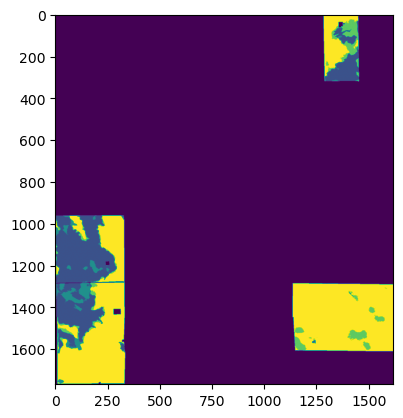

<AxesSubplot:>

In [42]:
da_result = xr.zeros_like(da_active)
da_result = da_result + ((da_active > 0) & (pts_density_xr >= pts_thresh))
da_result = da_result + ((da_active > 0) & (pts_density_xr < pts_thresh)) * 2
da_result = da_result + ((da_active == 0) & (pts_density_xr >= pts_thresh)) * 3
da_result = da_result + ((da_active == 0) & (pts_density_xr < pts_thresh)) * 4
show(da_result.data, clim=(0, 4))

In [43]:
pred_result_dict = {
    0: np.nan,
    1: 'True positive',
    2: 'False negative',
    3: 'False positive',
    4: 'True negative'
}
df_out['pred_result'] = da_result.to_dataframe(name='pred_result')['pred_result'].apply(lambda x: pred_result_dict[x])

In [44]:
from skimage.measure import label, regionprops
pr_burrow_labels = label((pts_density_xr >= pts_thresh))
pr_burrow_regions = regionprops(pr_burrow_labels)

pr_non_labels = label((pts_density_xr < pts_thresh))
pr_non_regions = regionprops(pr_non_labels)

In [45]:
area_thresh = 30
sm_burrow_labels = [x.label for x in pr_burrow_regions if (x.area * (cell_size**2 * 10e-4)) < area_thresh]
sm_non_labels = [x.label for x in pr_non_regions if (x.area * (cell_size**2 * 10e-4)) < area_thresh]
xr_burrow_labels = (xr.ones_like(pts_density_xr) * pr_burrow_labels).astype('int')
xr_non_labels = (xr.ones_like(pts_density_xr) * pr_non_labels).astype('int')

In [46]:
df_out['sm_burrow_area'] = xr_burrow_labels.where(
    xr_burrow_labels.isin(sm_burrow_labels)).to_dataframe(
    name='sm_burrow_labels')['sm_burrow_labels'].notnull()
df_out['sm_non_area'] = xr_non_labels.where(
    xr_non_labels.isin(sm_non_labels)).to_dataframe(
    name='sm_non_labels')['sm_non_labels'].notnull()
df_out['sm_area'] = df_out['sm_burrow_area'] | df_out['sm_non_area']

<AxesSubplot:>

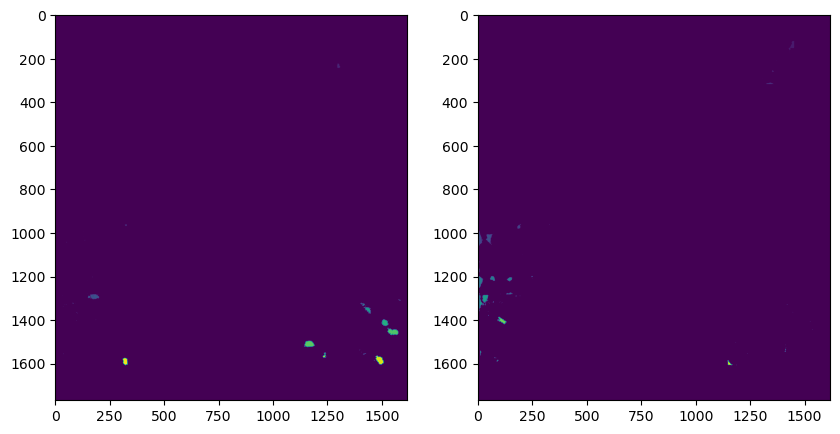

In [47]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 6))
show(xr_burrow_labels.where(xr_burrow_labels.isin(sm_burrow_labels), other=-1).data, ax=axs[0])
show(xr_non_labels.where(xr_non_labels.isin(sm_non_labels), other=-1).data, ax=axs[1])

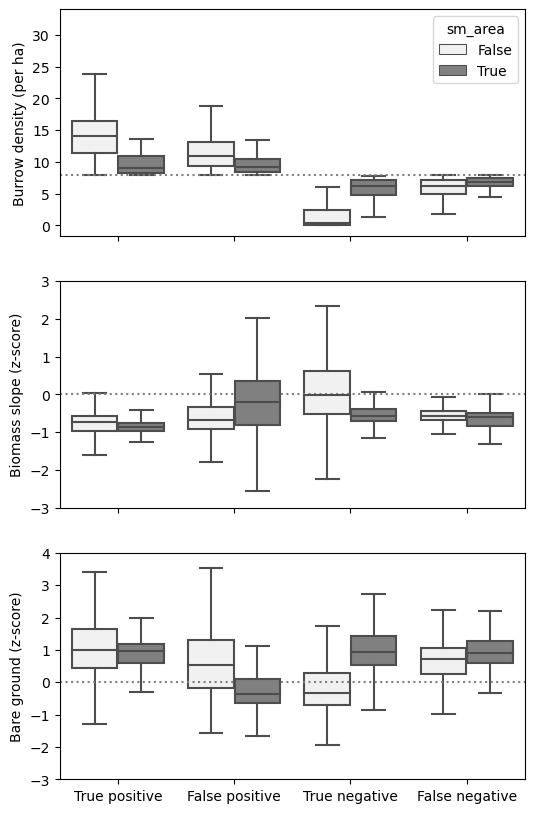

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting

In [48]:
fig, axs = plt.subplots(nrows=3, figsize=(6, 10),
            sharex=True)
sns.boxplot(x='pred_result', y='pts_density', data=df_out[df_out['pred_result'].notnull()],
            hue='sm_area',
            order=['True positive', 'False positive', 'True negative', 'False negative'],
            fliersize=0, color='grey', ax=axs[0])
axs[0].set_ylabel('Burrow density (per ha)')
axs[0].set_xlabel('')
axs[0].axhline(y=pts_thresh, linestyle='dotted', color='grey')

sns.boxplot(x='pred_result', y='bm_slope_z', data=df_out[df_out['pred_result'].notnull()],
            hue='sm_area',
            order=['True positive', 'False positive', 'True negative', 'False negative'],
            fliersize=0, color='grey', ax=axs[1])
axs[1].set_ylabel('Biomass slope (z-score)')
axs[1].set_xlabel('')
axs[1].set_ylim(-3.0, 3.0)
axs[1].legend().remove()
axs[1].axhline(y=0, linestyle='dotted', color='grey')

sns.boxplot(x='pred_result', y='bare_z', data=df_out[df_out['pred_result'].notnull()],
            hue='sm_area',
            order=['True positive', 'False positive', 'True negative', 'False negative'],
            fliersize=0, color='grey', ax=axs[2])
axs[2].set_ylabel('Bare ground (z-score)')
axs[2].set_xlabel('')
axs[2].set_ylim(-3.0, 4.0)
axs[2].legend().remove()
axs[2].axhline(y=0, linestyle='dotted', color='grey')